In [1]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import AdamW
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [2]:
df = pd.read_csv('Data.csv', sep=';')

In [3]:
df.head()

,k,lu,P0,I,gamma,sgamma,r,Psat,Lsat,loptim,lres,loptim/lres,Psat/Pall,Lsat/lu,f,rho,P0/Pall
0,3.89,3.69,12800000.0,80.0,2650.0,0.0,0.0001,1.430000e+08,18.5,2.261250e-08,2.257770e-08,0.001542,0.00132,5.01,0.736,0.000965,1.180000e-04
1,3.89,3.69,12800.0,80.0,1000.0,0.0,0.0001,9.800000e+07,16.7,1.585280e-07,1.580440e-07,0.003065,0.00240,4.52,0.736,0.002550,3.130000e-07
2,3.98,3.69,150000.0,500.0,2830.0,0.0,0.0001,1.130000e+09,20.3,2.061380e-08,2.057220e-08,0.002024,0.00156,5.49,0.735,0.001690,2.070000e-07
3,3.98,3.69,1500000.0,500.0,3160.0,0.0,0.0001,1.100000e+09,18.3,1.648760e-08,1.645770e-08,0.001814,0.00136,4.96,0.735,0.001510,1.850000e-06
4,3.98,3.69,150000.0,500.0,2650.0,0.0,0.0001,1.180000e+09,19.4,2.356200e-08,2.351110e-08,0.002164,0.00175,5.25,0.735,0.001800,2.210000e-07


In [4]:
df = df.dropna()

In [5]:
l = len(df)

In [6]:
df = df[df['Psat/Pall']<0.008]

In [7]:
df['log'] = np.log(df[['Psat/Pall']])
df['log0'] = np.log(df['P0']/df['I']/df['gamma']/511000)
df['optim'] = df['loptim/lres']/df['Psat/Pall']
df['Lsat/lu'] = np.log(df['Lsat/lu'])
df['sqgamma'] = np.log(df['gamma'])

In [8]:
df = df[df['optim']<2]

In [9]:
len(df)/l

0.9070138150903294

In [10]:
df['optim'] = df['loptim/lres']/df['rho']

In [11]:
df['optim'] = (df['optim'])

In [12]:
df1 = df.drop(columns=['gamma', 'P0', 'optim', 'P0/Pall', 'Psat', 'Lsat', 'loptim','lres', 'loptim/lres', 'Psat/Pall', 'Lsat/lu', 'f', 'rho', 'log'])

In [13]:
df1

,k,lu,I,sgamma,r,log0,sqgamma
0,3.89,3.69,80.0,0.00000,0.00010,-9.043511,7.882315
1,3.89,3.69,80.0,0.00000,0.00010,-14.976706,6.907755
2,3.98,3.69,500.0,0.00000,0.00010,-15.388374,7.948032
3,3.98,3.69,500.0,0.00000,0.00010,-13.196085,8.058327
4,3.98,3.69,500.0,0.00000,0.00010,-15.322657,7.882315
...,...,...,...,...,...,...,...
1877,1.72,1.99,7600.0,0.00005,0.00001,-16.247034,10.275051
1878,1.72,1.99,7600.0,0.00005,0.00001,-11.532665,10.165852
1879,3.29,1.99,4500.0,0.00005,0.00001,-11.512708,10.404263
1880,3.29,1.99,4500.0,0.00005,0.00001,-11.653787,10.545341


In [14]:
df2 = df.drop(columns=['sqgamma', 'k', 'lu', 'I', 'gamma', 'sgamma', 'r', 'log0', 'P0', 'P0/Pall', 'loptim','lres', 'loptim/lres', 'Psat/Pall', 'Lsat', 'f', 'rho', 'Psat'])

In [15]:
df2

,Lsat/lu,log,optim
0,1.611436,-6.630124,1.598041
1,1.508512,-6.032287,1.201894
2,1.702928,-6.463069,1.197420
3,1.601406,-6.600271,1.201364
4,1.658228,-6.348139,1.202222
...,...,...,...
1877,2.360854,-7.606921,0.798766
1878,1.829376,-7.086882,1.198454
1879,1.906575,-7.127156,1.200737
1880,2.034706,-7.268725,1.197812


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1, df2, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)



In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

scaler2 = MinMaxScaler()
scaler2.fit(y_train)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)
y_val = scaler2.transform(y_val)


In [18]:

X_train = torch.Tensor(X_train) 
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
validate_set = TensorDataset(X_val, y_val) 
test_set = TensorDataset(X_test, y_test) 


# Create Dataloader to read the data within batch sizes and put into memory. 
train_loader = DataLoader(train_set, batch_size = 20, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 20) 
test_loader = DataLoader(test_set, batch_size = 1)

In [19]:
train_dataset_array = next(iter(train_loader))[0].numpy()
train_dataset_array 

array([[0.4013378 , 0.38127092, 0.6040609 , 0.        , 0.2753623 ,
        0.8044071 , 0.4350645 ],
       [0.66220737, 0.8929766 , 0.17766498, 0.        , 0.00724638,
        0.30757636, 0.959728  ],
       [0.7792642 , 0.6588629 , 0.00101523, 0.        , 0.11594203,
        0.3100731 , 0.62002826],
       [0.5117057 , 0.55518395, 0.05583756, 0.        , 0.85507244,
        0.33094713, 0.47627386],
       [0.5117057 , 0.9632107 , 0.00101523, 0.        , 0.2753623 ,
        0.71729445, 0.4479199 ],
       [0.13043478, 0.4381271 , 0.5025381 , 0.        , 0.10144927,
        0.49303788, 0.7217358 ],
       [0.909699  , 0.54180604, 0.00203046, 0.        , 0.85507244,
        0.2950984 , 0.47627386],
       [0.40802675, 0.7926421 , 0.97969544, 0.05      , 0.        ,
        0.16117097, 0.98525083],
       [0.5585284 , 0.26755852, 0.04568528, 0.5       , 0.02898551,
        0.8213743 , 0.46791616],
       [0.6187291 , 0.6588629 , 0.05583756, 1.        , 0.10144927,
        0.41544142, 0.5

In [20]:
# Define model parameters 
input_size = list(X_train.shape)[1]   
output_size = list(y_train.shape)[1]  



# Define neural network 
class Network(nn.Module): 
    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        self.conv_stack = nn.Sequential(
        nn.Linear(input_size, 100), 
        nn.Tanh(),
        nn.Dropout(p=0.1),
        nn.Linear(100, 50),
        nn.Tanh(), 
        nn.Dropout(p=0.1),
        nn.Linear(50, 30),
        nn.Tanh(),
        nn.Dropout(p=0.1),
        nn.Linear(30, output_size) )
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x): 
        return self.conv_stack(x)
    
        # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("tanh")
        for child in self.conv_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight,
                                                 gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight,
                                                  gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model,
                optimizer,
                criterion,
                train_loader):
    loss_history = []
    for batch in train_loader: 
        optimizer.zero_grad()
        x_train, y_train = batch # parse data
        x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
        y_pred = model(x_train) # get predictions
        loss = criterion(y_pred, y_train) # compute loss
        loss_history.append(loss.cpu().detach().numpy()) # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [22]:
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss = criterion(y_pred, y_train) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [23]:
from tqdm import tqdm

def train_model(model, optimizer, model_name=None, n_epochs=5):
  
    criterion = nn.MSELoss().to(device)

    train_history = {}
    train_history['model_name'] = model_name
    train_history['loss_on_train'] = []
    train_history['loss_on_test'] = []

    for epoch in tqdm(range(n_epochs)):
        loss_on_train = train_epoch(model,
                                    optimizer,
                                    criterion,
                                    train_loader)
        _, loss_on_test = validate(model,
                                   criterion,
                                   validate_loader)
        train_history['loss_on_train'].append(np.mean(loss_on_train))
        train_history['loss_on_test'].append(np.mean(loss_on_test))
        scheduler.step()
    return train_history

In [24]:
def exponential_smoothing(scalars, weight):  
    last = scalars[0]  
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                        
        last = smoothed_val                                 

    return smoothed


def plot_history(history, n_epochs=5, smooth_val=0.9):
    fig, ax =  plt.subplots(3, 1, figsize=(12, 14))
    for stage_idx, (stage_lbl, stage_title) in enumerate(
        zip(['loss_on_train', 'loss_on_test'],
            ['train loss', 'val loss'])):
        # plot history on each learning step
        epoch_len = len(history[stage_lbl])//n_epochs
        full_stage_len = len(history[stage_lbl])
        ax[stage_idx].plot(exponential_smoothing(history[stage_lbl], smooth_val),
                           label='smoothed',
                           color='m')
        ax[stage_idx].plot(history[stage_lbl],
                           label='raw',
                           alpha=0.2,
                           color='c')
        ax[stage_idx].set_title(stage_title)
        ax[stage_idx].set_xlabel('epochs')
        ax[stage_idx].set_ylabel('loss')
        epochs_ticks_positions = np.arange(stop=full_stage_len+1,
                                           step=epoch_len)
        ax[stage_idx].set_xticks(np.arange(0,1000,100))
        ax[stage_idx].set_xticklabels(np.arange(0,1000,100))
        ax[stage_idx].legend()

        # plot mean train and test loss combined
        mean_loss_on_epoch = [np.mean(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]
        std_loss_on_epoch = [np.std(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]

        ax[2].set_title('\nAverage loss per epoch')
        ax[2].errorbar(np.arange(n_epochs) + stage_idx / 30.,
                       mean_loss_on_epoch,
                       yerr=std_loss_on_epoch,
                       capsize=5,
                       fmt="X--",
                       label=stage_title)
        ax[2].set_xticks(np.arange(0,1000,100))
        ax[2].set_xticklabels(np.arange(0,1000,100))
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('loss')
        ax[2].legend()

    fig.suptitle(history['model_name'], fontsize=24)
    plt.show()

In [25]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

model = Network(input_size,output_size).to(device) 
optimizer = optim.AdamW(model.parameters(), lr=0.001)

lambda1 = lambda epoch: 0.998 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

n_epochs = 1000
history = train_model(model, optimizer, model_name='model', n_epochs=n_epochs)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.94it/s]


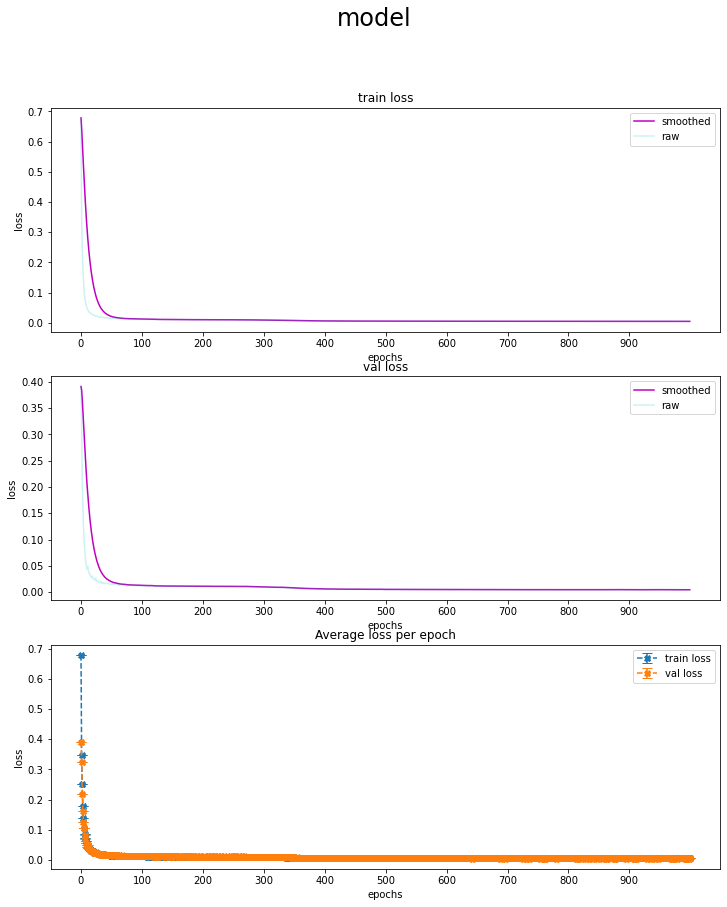

In [26]:
plot_history(history, n_epochs=n_epochs)


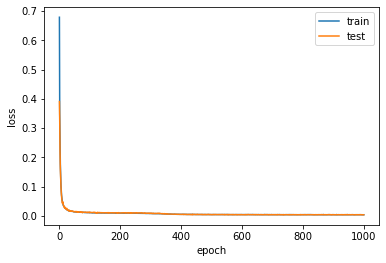

In [27]:
plt.plot(range(1,n_epochs+1), (history['loss_on_train']), label='train')
plt.plot(range(1,n_epochs+1), (history['loss_on_test']), label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [28]:
model.eval()

Network(
  (conv_stack): Sequential(
    (0): Linear(in_features=7, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=50, out_features=30, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=30, out_features=3, bias=True)
  )
)

In [29]:
def relative_abs_error(true, pred):
    num = (np.abs(true - pred))
    den = (np.abs(true))
    squared_error = num/den
    rrmse_loss = np.sum(squared_error)
    return rrmse_loss/len(true)


def test(model, val_loader):
    cumloss1 = 0
    cumloss2 = 0
    cumloss3 = 0
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            y_pred = scaler2.inverse_transform(y_pred.cpu().detach().numpy())
            y_train = scaler2.inverse_transform(y_train.cpu().detach().numpy())
            loss1 = relative_abs_error(np.exp(y_pred[:,0]), 
                                                    np.exp(y_train[:,0])) # compute loss
            loss2 = relative_abs_error(np.exp(y_pred[:,1]), 
                                                    np.exp(y_train[:,1]))
            loss3 = relative_abs_error((y_pred[:,2]), 
                                                    (y_train[:,2]))
            cumloss1 += loss1
            cumloss2 += loss2
            cumloss3 += loss3
            l1.append(loss1)
            l2.append(loss2)
            l3.append(loss3)
            l4.append(x_train.cpu().detach().numpy())
    return cumloss1 / len(val_loader), cumloss2 / len(val_loader), cumloss3 / len(val_loader), l1, l2, l3, l4


l = test(model, test_loader)
print('acc for Lsat=', l[0],'\n' 'acc for Psat=', l[1], '\n' 'acc for optim=', l[2])

acc for Lsat= 0.065552443275446 
acc for Psat= 0.10732222124198942 
acc for optim= 0.15954904406799864


Text(0.5, 1.0, 'Lsat error')

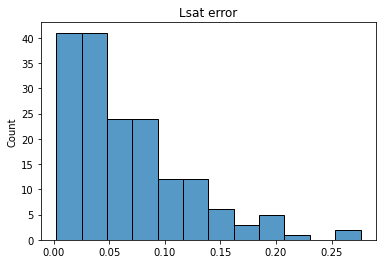

In [30]:
sns.histplot(l[3])
plt.title("Lsat error")

Text(0.5, 1.0, 'Power error')

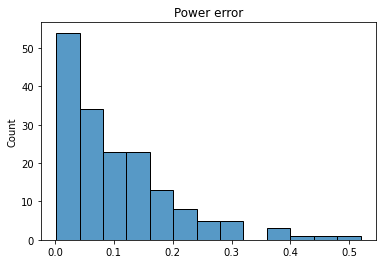

In [31]:
sns.histplot(l[4])
plt.title("Power error")

In [32]:
pd.Series(l[4]).sort_values().tail(20)
#scaler.inverse_transform(np.array([X_test[103].cpu().detach().numpy()]))

47     0.209955
161    0.221301
78     0.233212
10     0.236216
9      0.241297
86     0.246077
160    0.256137
135    0.261334
27     0.267589
166    0.284393
40     0.294310
42     0.295743
33     0.297886
46     0.307622
126    0.371640
96     0.385888
159    0.386803
34     0.433962
169    0.451898
64     0.518945
dtype: float64

Text(0.5, 1.0, 'optim error')

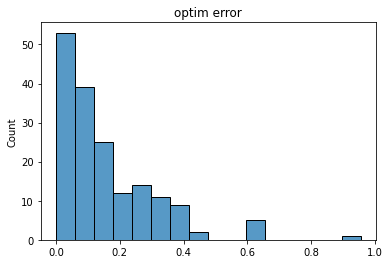

In [33]:
sns.histplot(l[5])
plt.title("optim error")

In [34]:
from scipy.special import jv
X = pd.DataFrame({'k':[2.13], 'lu':[2.8], 'I':[56],  'sgamma':[0.0002], 
                  'r':[0.00012], 'log0':[10], 'sqgamma': [np.log(300)]})

P_0 = X['log0'][0]

ksi = X['k']**2/(1+X['k']**2/2)/4
f = jv(0,ksi)-jv(1,ksi)
rho = 1/2/(np.exp(X['sqgamma']))*(X['I']/X['r']**2/np.pi/4/np.pi/17000*(X['lu']/100*X['k']*f)**2)**(1/3)

X['log0'] = np.log(X['log0']/X['I']/np.exp(X['sqgamma'])/511000)

X2 = scaler.transform(X)

input1 = torch.Tensor(X2)

a = (model(input1.to(device))).cpu().detach().numpy()
a= scaler2.inverse_transform(a)



L_sat = np.exp(a[0][0])*X['lu'][0]
P_sat = (np.exp(a[0][1])*np.exp(X['sqgamma'])*511000*X['I'])[0]

print('Lsat=', L_sat, 'Psat=', P_sat, 
'loptim=',(((a[0][2])*rho+1)*X['lu']/100/2/np.exp(X['sqgamma'])/np.exp(X['sqgamma'])*(1+X['k']*X['k']/2))[0])

Lsat= 13.48998565673828 Psat= 20224161.87431663 loptim= 5.104183442041095e-07


In [35]:
len(df)

1707

20724517.98186832


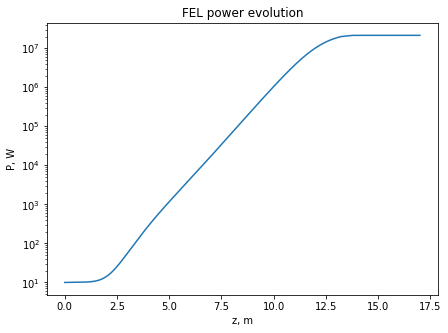

In [36]:
def P(z,P_0,P_sat,L_sat):
    def A(z,L):
        return 1/9*(3+2*np.cosh(z/L)+4*np.cos(3**(0.5)/2*z/L)*np.cosh(z/(2*L)))
    L = L_sat/1.1/np.log(9*P_sat/P_0)
    if z<0.98*L_sat:
        return P_0*(A(z,L)*np.exp(0.233*z/L_sat))/(1+P_0/P_sat*(A(z,L)-1))
    elif 1.02*L_sat>=z>=0.98*L_sat:
        return np.exp(((1.02-z/L_sat)*np.log(P_0*(A(0.98*L_sat,L)*np.exp(0.233*0.98*L_sat/L_sat))/(1+P_0/P_sat*(A(0.98*L_sat,L)-1)))+
    (z/L_sat-0.98)*np.log(P_0*(A(L_sat,L)*np.exp(0.233*L_sat/L_sat))/(1+P_0/P_sat*(A(L_sat,L)-1))))/(0.04))
    else: 
        return P_0*(A(L_sat,L)*np.exp(0.233*L_sat/L_sat))/(1+P_0/P_sat*(A(L_sat,L)-1))

print(P(L_sat,P_0,P_sat,L_sat))

 
# exponential function y = 10^x
data = [P(i,P_0,P_sat,L_sat) for i in np.arange(0, int(1.3*L_sat), X['lu'][0]/100)]


plt.figure(figsize=(7, 5))
# convert y-axis to Logarithmic scale
plt.yscale("log")
plt.xlabel('z, m')
plt.ylabel('P, W')
plt.title('FEL power evolution')

 
plt.plot(np.arange(0, int(1.3*L_sat), X['lu'][0]/100), data)

In [37]:
data = [i.item() for i in data]

In [38]:
pd.DataFrame(data).to_csv('pandas.txt', header=None, index=None, sep=' ', mode='w')

In [39]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset


In [40]:
criterion = nn.MSELoss()
set_random_seed(42)

num_epochs=1000
batch_size=64
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}


In [41]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc1':[], 'test_acc2':[], 
          'test_acc3':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(df1)))):

    print('Fold {}'.format(fold + 1))
    
    X_train = df1.iloc[train_idx]
    X_test = df1.iloc[val_idx]
    y_train = df2.iloc[train_idx]
    y_test = df2.iloc[val_idx]
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    scaler2 = MinMaxScaler()
    scaler2.fit(y_train)

    y_train = scaler2.transform(y_train)
    y_test = scaler2.transform(y_test)
    
    
    X_train = torch.Tensor(X_train) 
    y_train = torch.Tensor(y_train)

    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)

    train_set = TensorDataset(X_train, y_train) 
    test_set = TensorDataset(X_test, y_test) 


    # Create Dataloader to read the data within batch sizes and put into memory. 
    train_loader = DataLoader(train_set, batch_size = 20, shuffle = True) 
    test_loader = DataLoader(test_set, batch_size = 20)

    
    model = Network(input_size,output_size).to(device) 
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    
    lambda1 = lambda epoch: 0.998 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)


    for epoch in range(num_epochs):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        train_loss = float(np.mean(loss_on_train))
        _, loss_on_test = validate(model, criterion, test_loader)
        test_loss = float(np.mean(loss_on_test))
        model.eval()
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        scheduler.step()
        
        print("Epoch:{}/{}".format(epoch + 1, num_epochs))
        print('Loss on train=', train_loss)
        print('Loss on test=', test_loss)
        print('acc for Lsat=', test_acc[0],'\n' 'acc for Psat=', test_acc[1], '\n' 'acc for optim=', test_acc[2])
        
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    #history['train_acc'].append(train_acc)
    history['test_acc1'].append(test_acc[0])  
    history['test_acc2'].append(test_acc[1])  
    history['test_acc3'].append(test_acc[2])  

Fold 1
Epoch:1/1000
Loss on train= 0.683517336845398
Loss on test= 0.4171731770038605
acc for Lsat= 0.650495759314961 
acc for Psat= 0.48116040792730125 
acc for optim= 0.27580630886885854
Epoch:2/1000
Loss on train= 0.3571556508541107
Loss on test= 0.33711761236190796
acc for Lsat= 0.5553442584143744 
acc for Psat= 1.0582947585317823 
acc for optim= 0.3182655278179381
Epoch:3/1000
Loss on train= 0.25519058108329773
Loss on test= 0.22258074581623077
acc for Lsat= 0.45130210187700054 
acc for Psat= 0.563509804672665 
acc for optim= 0.20960108008649614
Epoch:4/1000
Loss on train= 0.18813233077526093
Loss on test= 0.1739591509103775
acc for Lsat= 0.3284255464871725 
acc for Psat= 0.4598560823334588 
acc for optim= 0.2276945927904712
Epoch:5/1000
Loss on train= 0.1390036940574646
Loss on test= 0.1296844780445099
acc for Lsat= 0.34623688591851126 
acc for Psat= 0.42666176888677815 
acc for optim= 0.2065661138130559
Epoch:6/1000
Loss on train= 0.10826586186885834
Loss on test= 0.097760081291

In [42]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_test_acc1 = np.mean(history['test_acc1'])
std1 = np.std(history['test_acc1'])
avg_test_acc2 = np.mean(history['test_acc2'])
std2 = np.std(history['test_acc2'])
avg_test_acc3 = np.mean(history['test_acc3'])
std3 = np.std(history['test_acc3'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Lsat Acc: {:.3f} +- {:.3f} \t Average Psat Acc: {:.3f} +- {:.3f} \t Average Loptim Acc: {:.3f} +- {:.3f}".
      format(avg_train_loss,avg_test_loss,avg_test_acc1,std1, avg_test_acc2, std2,
avg_test_acc3, std3))  

Performance of 5 fold cross validation
Average Training Loss: 0.0049 	 Average Test Loss: 0.0053 	 Average Lsat Acc: 0.078 +- 0.005 	 Average Psat Acc: 0.110 +- 0.008 	 Average Loptim Acc: 0.144 +- 0.010
